In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from deepxde.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


## Simplified 1-D


$
\begin{align}
&  \frac{\partial ^2 u}{\partial s^2}  = 0  \\
u(s=0) = 1 \hspace{1em} & u(s=1) = 0
\end{align}
$


In [34]:
def pde(s,u):
    return dde.grad.hessian(u,s)

geom = dde.geometry.Interval(0, 1)

def start_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def end_bound(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def func(s):
    return 1 - s

bc_start = dde.DirichletBC(geom, lambda x: 1, start_bound)
bc_end = dde.DirichletBC(geom, lambda x:0, end_bound)

data = dde.data.PDE(
    geom,
    pde,
    [bc_start, bc_end],
    num_domain=100,
    num_boundary=30,
    num_test=30,
    solution=func,
    train_distribution='uniform'
)

layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
# net.outputs_modify(lambda x, y: x * y)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)




Compiling model...
Building feed-forward neural network...
'build' took 0.050337 s



/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.366014 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.77e-02, 1.00e+00, 8.61e-02]    [1.78e-02, 0.00e+00, 0.00e+00]    [1.18e+00]    
1000      [1.79e-05, 6.48e-09, 1.98e-09]    [1.60e-05, 0.00e+00, 0.00e+00]    [2.13e-04]    
2000      [1.06e-05, 1.82e-09, 1.02e-09]    [9.58e-06, 0.00e+00, 0.00e+00]    [1.52e-04]    
3000      [6.23e-06, 7.75e-10, 4.38e-10]    [5.67e-06, 0.00e+00, 0.00e+00]    [1.14e-04]    
4000      [4.25e-06, 1.77e-06, 2.52e-05]    [4.56e-06, 0.00e+00, 0.00e+00]    [5.89e-03]    
5000      [2.31e-06, 2.70e-07, 2.45e-06]    [2.27e-06, 0.00e+00, 0.00e+00]    [1.91e-03]    

Best model at step 5000:
  train loss: 5.03e-06
  test loss: 2.27e-06
  test metric: [1.91e-03]

'train' took 27.283603 s



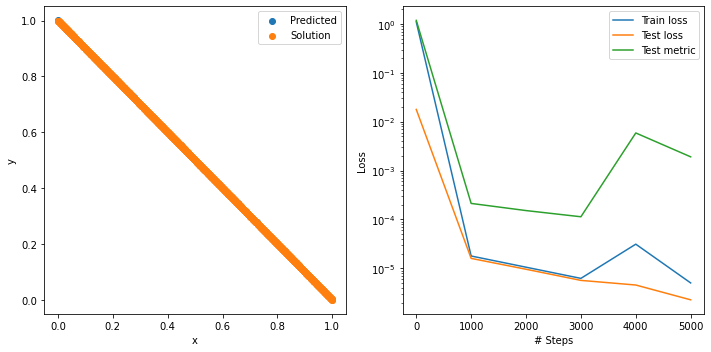

In [36]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
s = geom.uniform_points(1000, True)
z = func(s)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(X_test.flatten(), best_y.flatten(), label='Predicted')
ax[0].scatter(s, z, label='Solution')
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

ax[1].semilogy(losshistory.steps, loss_train, label="Train loss")
ax[1].semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    ax[1].semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("# Steps")
ax[1].legend()

fig.tight_layout()